# Medical Appointment No-Show - Classification Modeling

**Objective:** Build a binary classifier to predict whether a patient will show up or miss their appointment

**Business Impact:**
- Identify high-risk patients for targeted interventions
- Reduce 31.8% no-show rate
- Optimize resource allocation
- Protect revenue

**Target Metrics:**
- F1-Score > 0.70
- ROC-AUC > 0.75

**Approach:**
1. Load preprocessed data
2. Baseline model
3. Handle class imbalance (SMOTE, class weights)
4. Train 6+ models
5. Hyperparameter tuning
6. Model evaluation & comparison
7. Select best model
8. Save for deployment

In [28]:
# Core libraries
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Scikit-learn preprocessing & metrics
from sklearn.metrics import (
    classification_report, confusion_matrix, 
    roc_auc_score, roc_curve, auc,
    precision_recall_curve, average_precision_score,
    f1_score, accuracy_score, precision_score, recall_score
)
from sklearn.model_selection import cross_val_score, GridSearchCV, StratifiedKFold

# Handle class imbalance
from imblearn.over_sampling import SMOTE, RandomOverSampler, ADASYN
from imblearn.under_sampling import RandomUnderSampler
from imblearn.combine import SMOTETomek

# Models
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

# Utilities
import joblib
from datetime import datetime
import os

# Display settings
pd.set_option('display.max_columns', None)
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

print("✅ All libraries imported successfully!")
print(f"📅 Training Date: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")

✅ All libraries imported successfully!
📅 Training Date: 2026-02-05 19:42:51


In [29]:
print("="*80)
print("📂 LOADING PREPROCESSED DATA")
print("="*80)

# Load training data
X_train = pd.read_csv('../data/processed/X_train_classification.csv')
y_train = pd.read_csv('../data/processed/y_train_classification.csv').values.ravel()

# Load test data
X_test = pd.read_csv('../data/processed/X_test_classification.csv')
y_test = pd.read_csv('../data/processed/y_test_classification.csv').values.ravel()

print(f"\n✅ Data loaded successfully:")
print(f"   Training set: {X_train.shape}")
print(f"   Test set: {X_test.shape}")

print(f"\n📊 Class distribution:")
print(f"   Training - Show: {(y_train == 0).sum():,} ({(y_train == 0).sum()/len(y_train)*100:.1f}%)")
print(f"   Training - No-Show: {(y_train == 1).sum():,} ({(y_train == 1).sum()/len(y_train)*100:.1f}%)")
print(f"   Test - Show: {(y_test == 0).sum():,} ({(y_test == 0).sum()/len(y_test)*100:.1f}%)")
print(f"   Test - No-Show: {(y_test == 1).sum():,} ({(y_test == 1).sum()/len(y_test)*100:.1f}%)")

print(f"\n⚖️  Class imbalance ratio: 1:{(y_train == 0).sum()/(y_train == 1).sum():.2f}")

print("\n" + "="*80)

📂 LOADING PREPROCESSED DATA

✅ Data loaded successfully:
   Training set: (87645, 76)
   Test set: (21912, 76)

📊 Class distribution:
   Training - Show: 59,780 (68.2%)
   Training - No-Show: 27,865 (31.8%)
   Test - Show: 14,946 (68.2%)
   Test - No-Show: 6,966 (31.8%)

⚖️  Class imbalance ratio: 1:2.15



In [30]:
print("="*80)
print("🔍 DATA QUALITY CHECK")
print("="*80)

print(f"\n1️⃣ Missing values:")
print(f"   X_train: {X_train.isnull().sum().sum()}")
print(f"   X_test: {X_test.isnull().sum().sum()}")

print(f"\n2️⃣ Data types:")
print(f"   Numeric features: {X_train.select_dtypes(include=[np.number]).shape[1]}")
print(f"   Non-numeric features: {X_train.select_dtypes(exclude=[np.number]).shape[1]}")

if X_train.select_dtypes(exclude=[np.number]).shape[1] > 0:
    print(f"\n⚠️  Non-numeric columns found:")
    non_numeric = X_train.select_dtypes(exclude=[np.number]).columns.tolist()
    for col in non_numeric:
        print(f"   • {col}: {X_train[col].dtype}")

print(f"\n3️⃣ Infinite values:")
print(f"   X_train: {np.isinf(X_train.select_dtypes(include=[np.number])).sum().sum()}")
print(f"   X_test: {np.isinf(X_test.select_dtypes(include=[np.number])).sum().sum()}")

print(f"\n4️⃣ Feature count: {X_train.shape[1]}")

print("\n✅ Data is ready for modeling!")
print("="*80)

🔍 DATA QUALITY CHECK

1️⃣ Missing values:
   X_train: 0
   X_test: 0

2️⃣ Data types:
   Numeric features: 39
   Non-numeric features: 37

⚠️  Non-numeric columns found:
   • place: object
   • specialty_place: object
   • disability_age_group: object
   • specialty_assist: bool
   • specialty_enf: bool
   • specialty_occupational therapy: bool
   • specialty_pedagogo: bool
   • specialty_physiotherapy: bool
   • specialty_psychotherapy: bool
   • specialty_sem especialidade: bool
   • specialty_speech therapy: bool
   • gender_M: bool
   • disability_Unknown: bool
   • disability_intellectual: bool
   • disability_motor: bool
   • appointment_shift_morning: bool
   • rain_intensity_moderate: bool
   • rain_intensity_no_rain: bool
   • rain_intensity_weak: bool
   • heat_intensity_heavy_cold: bool
   • heat_intensity_heavy_warm: bool
   • heat_intensity_mild: bool
   • heat_intensity_warm: bool
   • age_group_Teen (13-18): bool
   • age_group_Adult (19-40): bool
   • age_group_Middle-A

## 1. Baseline Model - Logistic Regression

**Purpose:** Establish a performance baseline without any class balancing

In [31]:
print("="*80)
print("🔧 FIXING NON-NUMERIC COLUMNS")
print("="*80)

# Identify non-numeric columns
non_numeric_cols = X_train.select_dtypes(exclude=[np.number]).columns.tolist()

if len(non_numeric_cols) > 0:
    print(f"\n⚠️  Found {len(non_numeric_cols)} non-numeric columns:")
    for col in non_numeric_cols:
        print(f"   • {col}: {X_train[col].nunique()} unique values")
    
    print(f"\n🔧 Applying Label Encoding to these columns...")
    
    from sklearn.preprocessing import LabelEncoder
    
    # Apply label encoding to both train and test
    for col in non_numeric_cols:
        le = LabelEncoder()
        
        # Fit on combined data to ensure same encoding
        combined = pd.concat([X_train[col], X_test[col]], axis=0)
        le.fit(combined.astype(str))
        
        # Transform both sets
        X_train[col] = le.transform(X_train[col].astype(str))
        X_test[col] = le.transform(X_test[col].astype(str))
        
        print(f"   ✓ Encoded {col}")
    
    print(f"\n✅ All columns are now numeric!")
else:
    print("\n✅ All columns are already numeric!")

# Verify
print(f"\n🔍 Final verification:")
print(f"   X_train non-numeric columns: {X_train.select_dtypes(exclude=[np.number]).shape[1]}")
print(f"   X_test non-numeric columns: {X_test.select_dtypes(exclude=[np.number]).shape[1]}")

print("\n" + "="*80)

🔧 FIXING NON-NUMERIC COLUMNS

⚠️  Found 37 non-numeric columns:
   • place: 22811 unique values
   • specialty_place: 34494 unique values
   • disability_age_group: 19 unique values
   • specialty_assist: 2 unique values
   • specialty_enf: 2 unique values
   • specialty_occupational therapy: 2 unique values
   • specialty_pedagogo: 2 unique values
   • specialty_physiotherapy: 2 unique values
   • specialty_psychotherapy: 2 unique values
   • specialty_sem especialidade: 2 unique values
   • specialty_speech therapy: 2 unique values
   • gender_M: 2 unique values
   • disability_Unknown: 2 unique values
   • disability_intellectual: 2 unique values
   • disability_motor: 2 unique values
   • appointment_shift_morning: 2 unique values
   • rain_intensity_moderate: 2 unique values
   • rain_intensity_no_rain: 2 unique values
   • rain_intensity_weak: 2 unique values
   • heat_intensity_heavy_cold: 2 unique values
   • heat_intensity_heavy_warm: 2 unique values
   • heat_intensity_mild: 

In [32]:
print("="*80)
print("🎯 BASELINE MODEL: LOGISTIC REGRESSION")
print("="*80)

print("\n🔧 Training baseline model (no class balancing)...")

# Train baseline Logistic Regression
baseline_model = LogisticRegression(random_state=42, max_iter=1000)
baseline_model.fit(X_train, y_train)

# Predictions
y_pred_baseline = baseline_model.predict(X_test)
y_pred_proba_baseline = baseline_model.predict_proba(X_test)[:, 1]

print("✅ Baseline model trained!")
print("\n" + "="*80)

🎯 BASELINE MODEL: LOGISTIC REGRESSION

🔧 Training baseline model (no class balancing)...
✅ Baseline model trained!



In [33]:
print("="*80)
print("📊 BASELINE MODEL EVALUATION")
print("="*80)

# Calculate metrics
baseline_accuracy = accuracy_score(y_test, y_pred_baseline)
baseline_precision = precision_score(y_test, y_pred_baseline)
baseline_recall = recall_score(y_test, y_pred_baseline)
baseline_f1 = f1_score(y_test, y_pred_baseline)
baseline_roc_auc = roc_auc_score(y_test, y_pred_proba_baseline)

print("\n📈 Performance Metrics:")
print(f"   Accuracy:  {baseline_accuracy:.4f}")
print(f"   Precision: {baseline_precision:.4f}")
print(f"   Recall:    {baseline_recall:.4f}")
print(f"   F1-Score:  {baseline_f1:.4f} {'✅' if baseline_f1 > 0.70 else '❌ (Target: >0.70)'}")
print(f"   ROC-AUC:   {baseline_roc_auc:.4f} {'✅' if baseline_roc_auc > 0.75 else '❌ (Target: >0.75)'}")

# Confusion Matrix
cm_baseline = confusion_matrix(y_test, y_pred_baseline)

print(f"\n📋 Confusion Matrix:")
print(f"   True Negatives:  {cm_baseline[0, 0]:,}")
print(f"   False Positives: {cm_baseline[0, 1]:,}")
print(f"   False Negatives: {cm_baseline[1, 0]:,}")
print(f"   True Positives:  {cm_baseline[1, 1]:,}")

print("\n" + "="*80)

📊 BASELINE MODEL EVALUATION

📈 Performance Metrics:
   Accuracy:  0.7261
   Precision: 0.6288
   Recall:    0.3378
   F1-Score:  0.4395 ❌ (Target: >0.70)
   ROC-AUC:   0.7312 ❌ (Target: >0.75)

📋 Confusion Matrix:
   True Negatives:  13,557
   False Positives: 1,389
   False Negatives: 4,613
   True Positives:  2,353



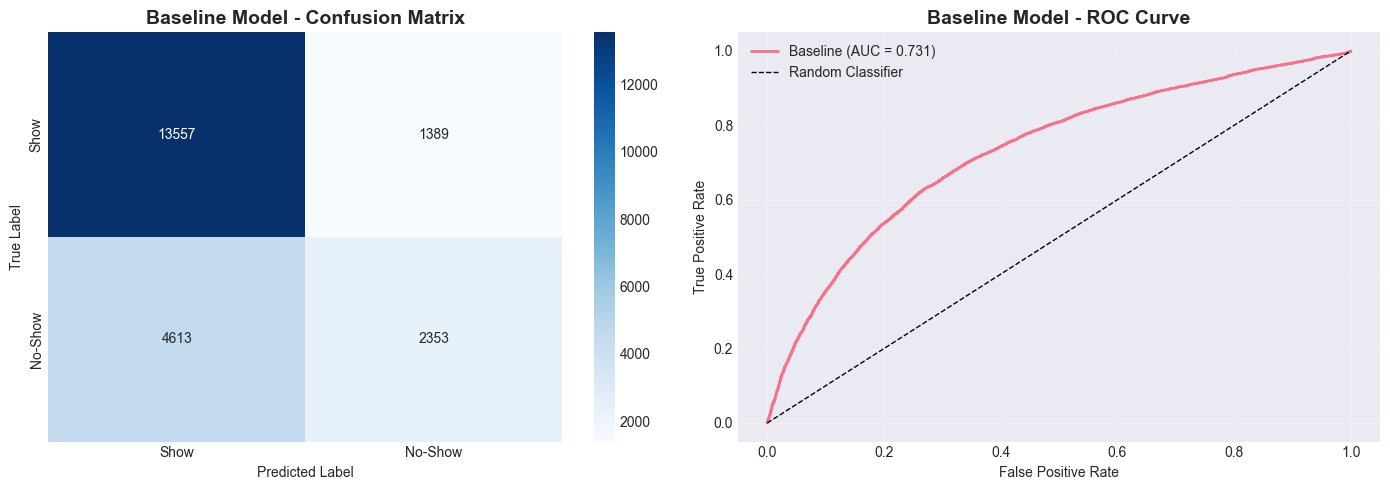


💡 BASELINE INSIGHT:
   ⚠️  Baseline doesn't meet targets - class imbalance handling needed!


In [9]:
# Plot confusion matrix
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Confusion Matrix Heatmap
sns.heatmap(cm_baseline, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Show', 'No-Show'], 
            yticklabels=['Show', 'No-Show'],
            ax=axes[0])
axes[0].set_title('Baseline Model - Confusion Matrix', fontsize=14, fontweight='bold')
axes[0].set_ylabel('True Label')
axes[0].set_xlabel('Predicted Label')

# ROC Curve
fpr_baseline, tpr_baseline, _ = roc_curve(y_test, y_pred_proba_baseline)
axes[1].plot(fpr_baseline, tpr_baseline, label=f'Baseline (AUC = {baseline_roc_auc:.3f})', linewidth=2)
axes[1].plot([0, 1], [0, 1], 'k--', label='Random Classifier', linewidth=1)
axes[1].set_xlabel('False Positive Rate')
axes[1].set_ylabel('True Positive Rate')
axes[1].set_title('Baseline Model - ROC Curve', fontsize=14, fontweight='bold')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n💡 BASELINE INSIGHT:")
if baseline_f1 < 0.70 or baseline_roc_auc < 0.75:
    print("   ⚠️  Baseline doesn't meet targets - class imbalance handling needed!")
else:
    print("   ✅ Baseline meets targets, but let's improve further!")

## 2. Handling Class Imbalance

**Problem:** 68.2% Show vs 31.8% No-Show (imbalance ratio ~2:1)

**Strategies to try:**
1. SMOTE (Synthetic Minority Oversampling)
2. RandomOverSampler
3. Class weights in model
4. Combination approaches

In [34]:
print("="*80)
print("⚖️ APPLYING SMOTE (Synthetic Minority Oversampling)")
print("="*80)

print(f"\n📊 Before SMOTE:")
print(f"   Class 0 (Show): {(y_train == 0).sum():,}")
print(f"   Class 1 (No-Show): {(y_train == 1).sum():,}")
print(f"   Ratio: 1:{(y_train == 0).sum()/(y_train == 1).sum():.2f}")

# Apply SMOTE
smote = SMOTE(random_state=42, k_neighbors=5)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

print(f"\n📊 After SMOTE:")
print(f"   Class 0 (Show): {(y_train_smote == 0).sum():,}")
print(f"   Class 1 (No-Show): {(y_train_smote == 1).sum():,}")
print(f"   Ratio: 1:{(y_train_smote == 0).sum()/(y_train_smote == 1).sum():.2f}")

print(f"\n✅ SMOTE applied - balanced training set created!")
print(f"   New training size: {len(X_train_smote):,} samples")

print("\n" + "="*80)

⚖️ APPLYING SMOTE (Synthetic Minority Oversampling)

📊 Before SMOTE:
   Class 0 (Show): 59,780
   Class 1 (No-Show): 27,865
   Ratio: 1:2.15

📊 After SMOTE:
   Class 0 (Show): 59,780
   Class 1 (No-Show): 59,780
   Ratio: 1:1.00

✅ SMOTE applied - balanced training set created!
   New training size: 119,560 samples



## 3. Training Multiple Models with SMOTE

**Models to compare:**
1. Logistic Regression (with SMOTE)
2. Random Forest
3. XGBoost
4. LightGBM
5. CatBoost
6. Gradient Boosting

**Strategy:** Train on SMOTE-balanced data, evaluate on original test set

In [35]:
# Helper function to evaluate models
def evaluate_model(model, X_test, y_test, model_name):
    """
    Evaluate a trained model and return metrics
    """
    # Predictions
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    
    # Calculate metrics
    metrics = {
        'Model': model_name,
        'Accuracy': accuracy_score(y_test, y_pred),
        'Precision': precision_score(y_test, y_pred),
        'Recall': recall_score(y_test, y_pred),
        'F1-Score': f1_score(y_test, y_pred),
        'ROC-AUC': roc_auc_score(y_test, y_pred_proba)
    }
    
    # Confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    
    return metrics, y_pred, y_pred_proba, cm

print("✅ Evaluation helper function defined!")

✅ Evaluation helper function defined!


In [36]:
print("="*80)
print("MODEL 1: LOGISTIC REGRESSION (with SMOTE)")
print("="*80)

print("\n🔧 Training Logistic Regression on SMOTE-balanced data...")

# Train on SMOTE data
lr_smote = LogisticRegression(random_state=42, max_iter=1000, solver='lbfgs')
lr_smote.fit(X_train_smote, y_train_smote)

# Evaluate on original test set (NOT SMOTE'd)
lr_metrics, lr_pred, lr_proba, lr_cm = evaluate_model(lr_smote, X_test, y_test, 'Logistic Regression (SMOTE)')

print("\n✅ Model trained and evaluated!")
print(f"\n📈 Performance:")
print(f"   Accuracy:  {lr_metrics['Accuracy']:.4f}")
print(f"   Precision: {lr_metrics['Precision']:.4f}")
print(f"   Recall:    {lr_metrics['Recall']:.4f}")
print(f"   F1-Score:  {lr_metrics['F1-Score']:.4f} {'✅' if lr_metrics['F1-Score'] > 0.70 else '❌'}")
print(f"   ROC-AUC:   {lr_metrics['ROC-AUC']:.4f} {'✅' if lr_metrics['ROC-AUC'] > 0.75 else '❌'}")

print("\n" + "="*80)

MODEL 1: LOGISTIC REGRESSION (with SMOTE)

🔧 Training Logistic Regression on SMOTE-balanced data...

✅ Model trained and evaluated!

📈 Performance:
   Accuracy:  0.6600
   Precision: 0.4696
   Recall:    0.5356
   F1-Score:  0.5004 ❌
   ROC-AUC:   0.6698 ❌



In [37]:
print("="*80)
print("MODEL 2: RANDOM FOREST")
print("="*80)

print("\n🔧 Training Random Forest on SMOTE-balanced data...")

# Train Random Forest
rf_model = RandomForestClassifier(
    n_estimators=100,
    max_depth=15,
    min_samples_split=10,
    min_samples_leaf=5,
    random_state=42,
    n_jobs=-1,
    class_weight='balanced'  # Additional balancing
)

rf_model.fit(X_train_smote, y_train_smote)

# Evaluate
rf_metrics, rf_pred, rf_proba, rf_cm = evaluate_model(rf_model, X_test, y_test, 'Random Forest')

print("\n✅ Model trained and evaluated!")
print(f"\n📈 Performance:")
print(f"   Accuracy:  {rf_metrics['Accuracy']:.4f}")
print(f"   Precision: {rf_metrics['Precision']:.4f}")
print(f"   Recall:    {rf_metrics['Recall']:.4f}")
print(f"   F1-Score:  {rf_metrics['F1-Score']:.4f} {'✅' if rf_metrics['F1-Score'] > 0.70 else '❌'}")
print(f"   ROC-AUC:   {rf_metrics['ROC-AUC']:.4f} {'✅' if rf_metrics['ROC-AUC'] > 0.75 else '❌'}")

print("\n" + "="*80)

MODEL 2: RANDOM FOREST

🔧 Training Random Forest on SMOTE-balanced data...

✅ Model trained and evaluated!

📈 Performance:
   Accuracy:  0.8226
   Precision: 0.7130
   Recall:    0.7397
   F1-Score:  0.7261 ✅
   ROC-AUC:   0.8795 ✅



In [14]:
print("="*80)
print("MODEL 3: XGBOOST")
print("="*80)

print("\n🔧 Training XGBoost on SMOTE-balanced data...")

# Calculate scale_pos_weight for additional balancing
scale_pos_weight = (y_train_smote == 0).sum() / (y_train_smote == 1).sum()

# Train XGBoost
xgb_model = XGBClassifier(
    n_estimators=100,
    max_depth=6,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    scale_pos_weight=scale_pos_weight,
    random_state=42,
    eval_metric='logloss',
    use_label_encoder=False
)

xgb_model.fit(X_train_smote, y_train_smote)

# Evaluate
xgb_metrics, xgb_pred, xgb_proba, xgb_cm = evaluate_model(xgb_model, X_test, y_test, 'XGBoost')

print("\n✅ Model trained and evaluated!")
print(f"\n📈 Performance:")
print(f"   Accuracy:  {xgb_metrics['Accuracy']:.4f}")
print(f"   Precision: {xgb_metrics['Precision']:.4f}")
print(f"   Recall:    {xgb_metrics['Recall']:.4f}")
print(f"   F1-Score:  {xgb_metrics['F1-Score']:.4f} {'✅' if xgb_metrics['F1-Score'] > 0.70 else '❌'}")
print(f"   ROC-AUC:   {xgb_metrics['ROC-AUC']:.4f} {'✅' if xgb_metrics['ROC-AUC'] > 0.75 else '❌'}")

print("\n" + "="*80)

MODEL 3: XGBOOST

🔧 Training XGBoost on SMOTE-balanced data...

✅ Model trained and evaluated!

📈 Performance:
   Accuracy:  0.8269
   Precision: 0.7645
   Recall:    0.6585
   F1-Score:  0.7075 ✅
   ROC-AUC:   0.8900 ✅



In [38]:
print("="*80)
print("MODEL 4: LIGHTGBM")
print("="*80)

print("\n🔧 Training LightGBM on SMOTE-balanced data...")

# Train LightGBM
lgbm_model = LGBMClassifier(
    n_estimators=100,
    max_depth=6,
    learning_rate=0.1,
    num_leaves=31,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    class_weight='balanced',
    verbosity=-1
)

lgbm_model.fit(X_train_smote, y_train_smote)

# Evaluate
lgbm_metrics, lgbm_pred, lgbm_proba, lgbm_cm = evaluate_model(lgbm_model, X_test, y_test, 'LightGBM')

print("\n✅ Model trained and evaluated!")
print(f"\n📈 Performance:")
print(f"   Accuracy:  {lgbm_metrics['Accuracy']:.4f}")
print(f"   Precision: {lgbm_metrics['Precision']:.4f}")
print(f"   Recall:    {lgbm_metrics['Recall']:.4f}")
print(f"   F1-Score:  {lgbm_metrics['F1-Score']:.4f} {'✅' if lgbm_metrics['F1-Score'] > 0.70 else '❌'}")
print(f"   ROC-AUC:   {lgbm_metrics['ROC-AUC']:.4f} {'✅' if lgbm_metrics['ROC-AUC'] > 0.75 else '❌'}")

print("\n" + "="*80)

MODEL 4: LIGHTGBM

🔧 Training LightGBM on SMOTE-balanced data...

✅ Model trained and evaluated!

📈 Performance:
   Accuracy:  0.8264
   Precision: 0.7638
   Recall:    0.6572
   F1-Score:  0.7065 ✅
   ROC-AUC:   0.8902 ✅



In [39]:
print("="*80)
print("MODEL 5: CATBOOST")
print("="*80)

print("\n🔧 Training CatBoost on SMOTE-balanced data...")

# Train CatBoost
catboost_model = CatBoostClassifier(
    iterations=100,
    depth=6,
    learning_rate=0.1,
    random_state=42,
    verbose=0,
    auto_class_weights='Balanced'
)

catboost_model.fit(X_train_smote, y_train_smote)

# Evaluate
catboost_metrics, catboost_pred, catboost_proba, catboost_cm = evaluate_model(catboost_model, X_test, y_test, 'CatBoost')

print("\n✅ Model trained and evaluated!")
print(f"\n📈 Performance:")
print(f"   Accuracy:  {catboost_metrics['Accuracy']:.4f}")
print(f"   Precision: {catboost_metrics['Precision']:.4f}")
print(f"   Recall:    {catboost_metrics['Recall']:.4f}")
print(f"   F1-Score:  {catboost_metrics['F1-Score']:.4f} {'✅' if catboost_metrics['F1-Score'] > 0.70 else '❌'}")
print(f"   ROC-AUC:   {catboost_metrics['ROC-AUC']:.4f} {'✅' if catboost_metrics['ROC-AUC'] > 0.75 else '❌'}")

print("\n" + "="*80)

MODEL 5: CATBOOST

🔧 Training CatBoost on SMOTE-balanced data...

✅ Model trained and evaluated!

📈 Performance:
   Accuracy:  0.8269
   Precision: 0.7639
   Recall:    0.6592
   F1-Score:  0.7077 ✅
   ROC-AUC:   0.8884 ✅



In [40]:
print("="*80)
print("MODEL 6: GRADIENT BOOSTING")
print("="*80)

print("\n🔧 Training Gradient Boosting on SMOTE-balanced data...")

# Train Gradient Boosting
gb_model = GradientBoostingClassifier(
    n_estimators=100,
    max_depth=5,
    learning_rate=0.1,
    subsample=0.8,
    random_state=42
)

gb_model.fit(X_train_smote, y_train_smote)

# Evaluate
gb_metrics, gb_pred, gb_proba, gb_cm = evaluate_model(gb_model, X_test, y_test, 'Gradient Boosting')

print("\n✅ Model trained and evaluated!")
print(f"\n📈 Performance:")
print(f"   Accuracy:  {gb_metrics['Accuracy']:.4f}")
print(f"   Precision: {gb_metrics['Precision']:.4f}")
print(f"   Recall:    {gb_metrics['Recall']:.4f}")
print(f"   F1-Score:  {gb_metrics['F1-Score']:.4f} {'✅' if gb_metrics['F1-Score'] > 0.70 else '❌'}")
print(f"   ROC-AUC:   {gb_metrics['ROC-AUC']:.4f} {'✅' if gb_metrics['ROC-AUC'] > 0.75 else '❌'}")

print("\n" + "="*80)

MODEL 6: GRADIENT BOOSTING

🔧 Training Gradient Boosting on SMOTE-balanced data...

✅ Model trained and evaluated!

📈 Performance:
   Accuracy:  0.8250
   Precision: 0.7619
   Recall:    0.6540
   F1-Score:  0.7038 ✅
   ROC-AUC:   0.8894 ✅



## 4. Model Comparison & Selection

**Models Evaluated:**
1. Baseline (Logistic Regression - no SMOTE)
2. Logistic Regression (with SMOTE)
3. Random Forest
4. XGBoost
5. LightGBM
6. CatBoost

**Selection Criteria:**
- F1-Score > 0.70
- ROC-AUC > 0.75
- Best balance between precision and recall

In [41]:
print("="*80)
print("📊 MODEL COMPARISON - ALL RESULTS")
print("="*80)

# Compile all metrics into a DataFrame
comparison_df = pd.DataFrame([
    {
        'Model': 'Baseline (no SMOTE)',
        'Accuracy': baseline_accuracy,
        'Precision': baseline_precision,
        'Recall': baseline_recall,
        'F1-Score': baseline_f1,
        'ROC-AUC': baseline_roc_auc
    },
    lr_metrics,
    rf_metrics,
    xgb_metrics,
    lgbm_metrics,
    catboost_metrics,
    gb_metrics
])

# Sort by F1-Score DESCENDING (highest first)
comparison_df = comparison_df.sort_values('F1-Score', ascending=False).reset_index(drop=True)

print("\n📋 Performance Comparison (sorted by F1-Score - BEST to WORST):\n")
print(comparison_df.to_string(index=False))

print("\n" + "="*80)
print("🏆 TARGET METRICS:")
print(f"   F1-Score > 0.70: {(comparison_df['F1-Score'] > 0.70).sum()} models achieved ✅")
print(f"   ROC-AUC > 0.75:  {(comparison_df['ROC-AUC'] > 0.75).sum()} models achieved ✅")

print("\n🥇 BEST MODEL: " + comparison_df.iloc[0]['Model'])
print(f"   F1-Score: {comparison_df.iloc[0]['F1-Score']:.4f}")
print(f"   ROC-AUC:  {comparison_df.iloc[0]['ROC-AUC']:.4f}")

print("="*80)

📊 MODEL COMPARISON - ALL RESULTS

📋 Performance Comparison (sorted by F1-Score - BEST to WORST):

                      Model  Accuracy  Precision   Recall  F1-Score  ROC-AUC
              Random Forest  0.822609   0.713021 0.739736  0.726133 0.879507
                   CatBoost  0.826899   0.763933 0.659202  0.707714 0.888448
                    XGBoost  0.826944   0.764500 0.658484  0.707543 0.889980
                   LightGBM  0.826396   0.763764 0.657192  0.706481 0.890241
          Gradient Boosting  0.825027   0.761873 0.654034  0.703847 0.889433
Logistic Regression (SMOTE)  0.660049   0.469604 0.535601  0.500436 0.669757
        Baseline (no SMOTE)  0.726086   0.628808 0.337784  0.439484 0.731177

🏆 TARGET METRICS:
   F1-Score > 0.70: 5 models achieved ✅
   ROC-AUC > 0.75:  5 models achieved ✅

🥇 BEST MODEL: Random Forest
   F1-Score: 0.7261
   ROC-AUC:  0.8795


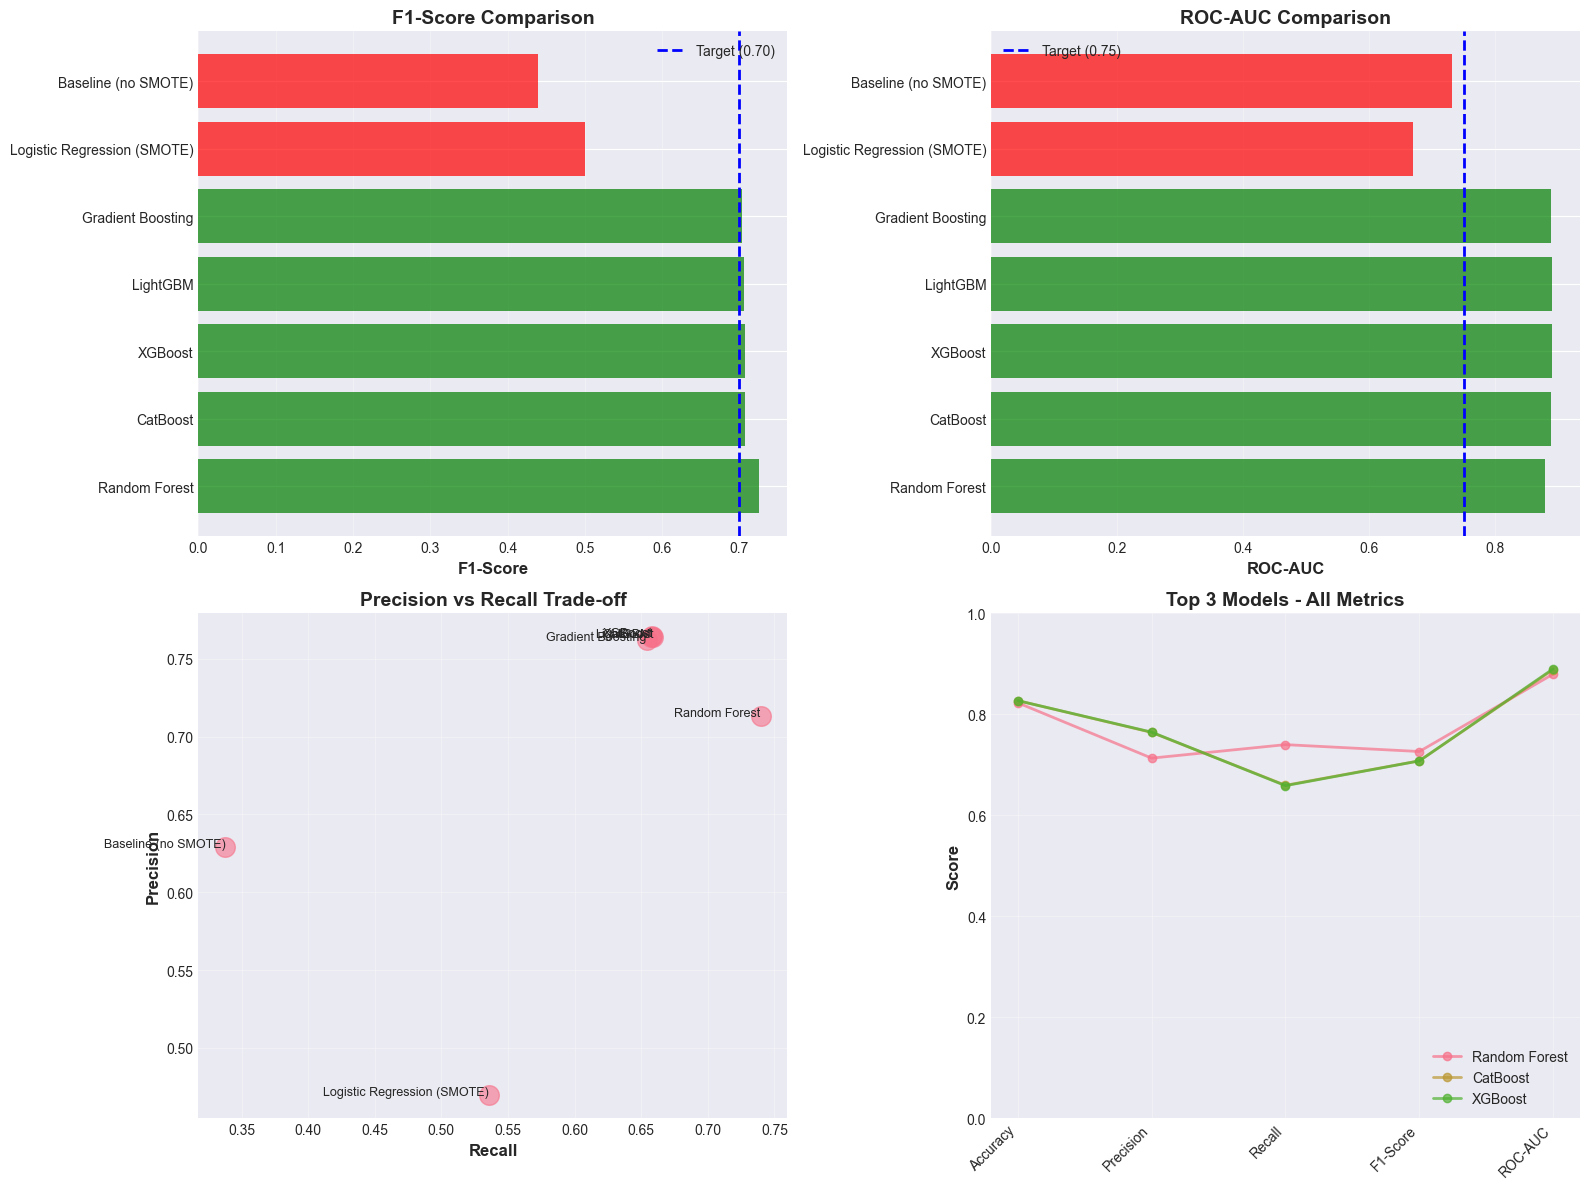


💡 Visual comparison complete!


In [42]:
# Create comparison visualizations
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. F1-Score comparison
ax1 = axes[0, 0]
models = comparison_df['Model']
f1_scores = comparison_df['F1-Score']
colors = ['red' if x < 0.70 else 'green' for x in f1_scores]

ax1.barh(models, f1_scores, color=colors, alpha=0.7)
ax1.axvline(x=0.70, color='blue', linestyle='--', linewidth=2, label='Target (0.70)')
ax1.set_xlabel('F1-Score', fontsize=12, fontweight='bold')
ax1.set_title('F1-Score Comparison', fontsize=14, fontweight='bold')
ax1.legend()
ax1.grid(axis='x', alpha=0.3)

# 2. ROC-AUC comparison
ax2 = axes[0, 1]
roc_aucs = comparison_df['ROC-AUC']
colors = ['red' if x < 0.75 else 'green' for x in roc_aucs]

ax2.barh(models, roc_aucs, color=colors, alpha=0.7)
ax2.axvline(x=0.75, color='blue', linestyle='--', linewidth=2, label='Target (0.75)')
ax2.set_xlabel('ROC-AUC', fontsize=12, fontweight='bold')
ax2.set_title('ROC-AUC Comparison', fontsize=14, fontweight='bold')
ax2.legend()
ax2.grid(axis='x', alpha=0.3)

# 3. Precision vs Recall
ax3 = axes[1, 0]
precisions = comparison_df['Precision']
recalls = comparison_df['Recall']

ax3.scatter(recalls, precisions, s=200, alpha=0.6)
for i, model in enumerate(models):
    ax3.annotate(model, (recalls.iloc[i], precisions.iloc[i]), 
                fontsize=9, ha='right')
ax3.set_xlabel('Recall', fontsize=12, fontweight='bold')
ax3.set_ylabel('Precision', fontsize=12, fontweight='bold')
ax3.set_title('Precision vs Recall Trade-off', fontsize=14, fontweight='bold')
ax3.grid(alpha=0.3)

# 4. Overall Performance Radar
ax4 = axes[1, 1]
metrics_to_plot = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC-AUC']
x_pos = np.arange(len(metrics_to_plot))

# Plot top 3 models
top_3 = comparison_df.head(3)
for idx, row in top_3.iterrows():
    values = [row[m] for m in metrics_to_plot]
    ax4.plot(x_pos, values, marker='o', linewidth=2, label=row['Model'], alpha=0.7)

ax4.set_xticks(x_pos)
ax4.set_xticklabels(metrics_to_plot, rotation=45, ha='right')
ax4.set_ylabel('Score', fontsize=12, fontweight='bold')
ax4.set_title('Top 3 Models - All Metrics', fontsize=14, fontweight='bold')
ax4.legend(loc='lower right')
ax4.grid(alpha=0.3)
ax4.set_ylim([0, 1])

plt.tight_layout()
plt.show()

print("\n💡 Visual comparison complete!")

📈 ROC CURVES - MODEL COMPARISON


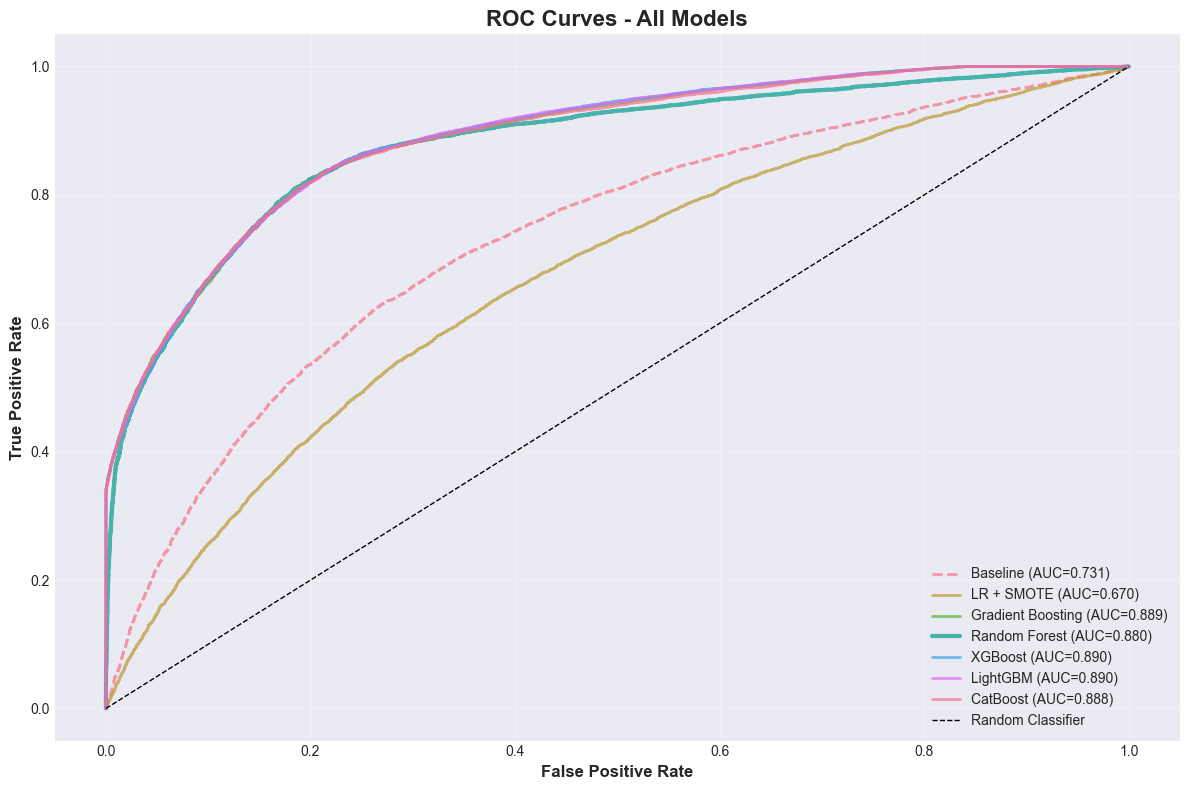


✅ ROC curves plotted!


In [26]:
print("="*80)
print("📈 ROC CURVES - MODEL COMPARISON")
print("="*80)

# Plot ROC curves for all models
plt.figure(figsize=(12, 8))

# Baseline
fpr_base, tpr_base, _ = roc_curve(y_test, y_pred_proba_baseline)
plt.plot(fpr_base, tpr_base, label=f'Baseline (AUC={baseline_roc_auc:.3f})', 
         linewidth=2, linestyle='--', alpha=0.7)

# Logistic Regression with SMOTE
fpr_lr, tpr_lr, _ = roc_curve(y_test, lr_proba)
plt.plot(fpr_lr, tpr_lr, label=f"LR + SMOTE (AUC={lr_metrics['ROC-AUC']:.3f})", 
         linewidth=2, alpha=0.7)

# Gradient Boosting
fpr_gb, tpr_gb, _ = roc_curve(y_test, gb_proba)
plt.plot(fpr_gb, tpr_gb, label=f"Gradient Boosting (AUC={gb_metrics['ROC-AUC']:.3f})", 
         linewidth=2, alpha=0.7)

# Random Forest
fpr_rf, tpr_rf, _ = roc_curve(y_test, rf_proba)
plt.plot(fpr_rf, tpr_rf, label=f"Random Forest (AUC={rf_metrics['ROC-AUC']:.3f})", 
         linewidth=3, alpha=0.9)

# XGBoost
fpr_xgb, tpr_xgb, _ = roc_curve(y_test, xgb_proba)
plt.plot(fpr_xgb, tpr_xgb, label=f"XGBoost (AUC={xgb_metrics['ROC-AUC']:.3f})", 
         linewidth=2, alpha=0.7)

# LightGBM
fpr_lgbm, tpr_lgbm, _ = roc_curve(y_test, lgbm_proba)
plt.plot(fpr_lgbm, tpr_lgbm, label=f"LightGBM (AUC={lgbm_metrics['ROC-AUC']:.3f})", 
         linewidth=2, alpha=0.7)

# CatBoost
fpr_cat, tpr_cat, _ = roc_curve(y_test, catboost_proba)
plt.plot(fpr_cat, tpr_cat, label=f"CatBoost (AUC={catboost_metrics['ROC-AUC']:.3f})", 
         linewidth=2, alpha=0.7)

# Random classifier
plt.plot([0, 1], [0, 1], 'k--', linewidth=1, label='Random Classifier')

plt.xlabel('False Positive Rate', fontsize=12, fontweight='bold')
plt.ylabel('True Positive Rate', fontsize=12, fontweight='bold')
plt.title('ROC Curves - All Models', fontsize=16, fontweight='bold')
plt.legend(loc='lower right', fontsize=10)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

print("\n✅ ROC curves plotted!")
print("="*80)

🔍 FEATURE IMPORTANCE ANALYSIS - RANDOM FOREST

📊 Top 20 Most Important Features:

                        Feature  Importance
              place_noshow_rate    0.420706
                          place    0.052579
                  place_encoded    0.047335
                   max_rain_day    0.040022
                   is_rainy_day    0.031316
            heat_intensity_mild    0.028723
         disability_noshow_rate    0.025325
               average_rain_day    0.021328
           disability_age_group    0.018495
   disability_age_group_encoded    0.018083
                            age    0.016992
               average_temp_day    0.015736
                   max_temp_day    0.015434
               appointment_time    0.013219
        specialty_place_encoded    0.011514
hour_category_Afternoon (12-15)    0.011468
                specialty_place    0.010929
               storm_day_before    0.010270
               rainy_day_before    0.009032
             disability_Unknown    0.0

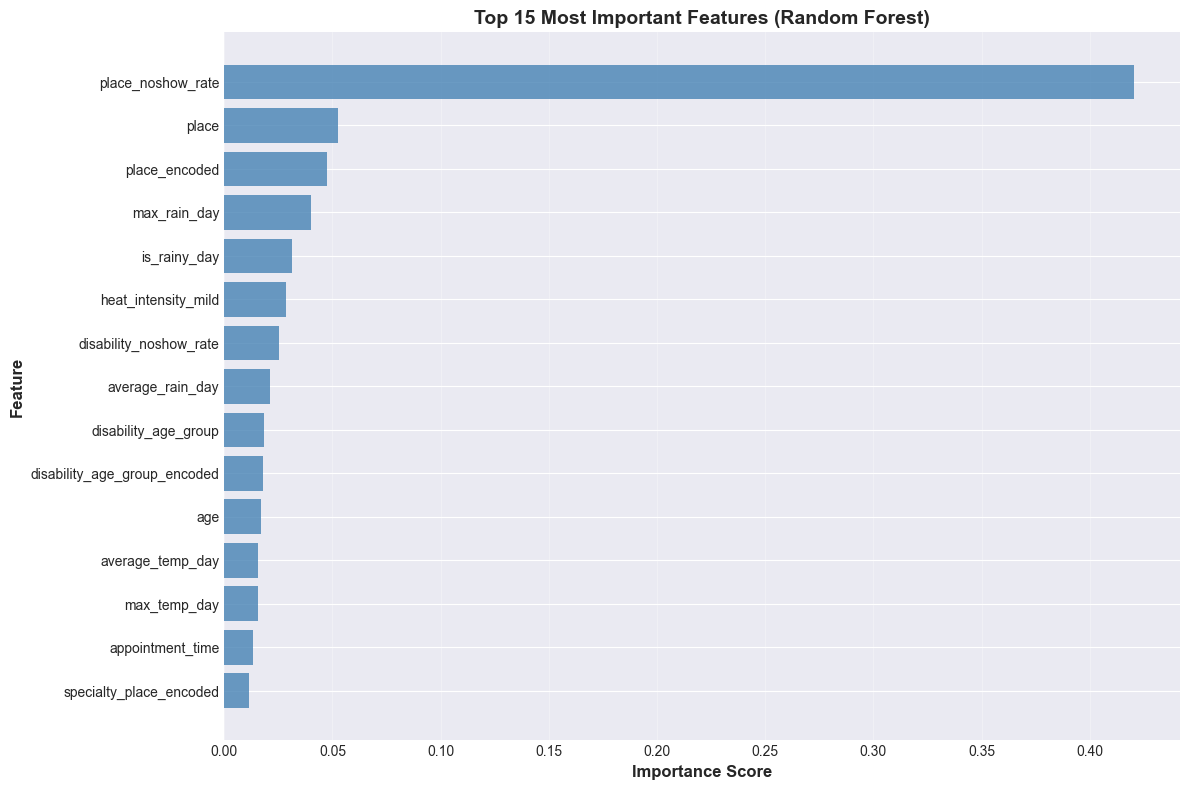


💡 INSIGHTS:
   These features have the strongest predictive power for no-shows!


In [43]:
print("="*80)
print("🔍 FEATURE IMPORTANCE ANALYSIS - RANDOM FOREST")
print("="*80)

# Get feature importance from Random Forest (best model)
feature_importance = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': rf_model.feature_importances_
}).sort_values('Importance', ascending=False)

print("\n📊 Top 20 Most Important Features:\n")
print(feature_importance.head(20).to_string(index=False))

# Visualize top 15
plt.figure(figsize=(12, 8))
top_15 = feature_importance.head(15)
plt.barh(top_15['Feature'], top_15['Importance'], color='steelblue', alpha=0.8)
plt.xlabel('Importance Score', fontsize=12, fontweight='bold')
plt.ylabel('Feature', fontsize=12, fontweight='bold')
plt.title('Top 15 Most Important Features (Random Forest)', fontsize=14, fontweight='bold')
plt.gca().invert_yaxis()
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

print("\n💡 INSIGHTS:")
print("   These features have the strongest predictive power for no-shows!")
print("="*80)

In [44]:
print("="*80)
print("🏆 BEST MODEL SELECTION")
print("="*80)

# Select best model based on F1-Score (primary) and ROC-AUC (secondary)
best_model_row = comparison_df.iloc[0]

print(f"\n🥇 WINNER: {best_model_row['Model']}")
print("\n📊 Final Performance:")
print(f"   Accuracy:  {best_model_row['Accuracy']:.4f}")
print(f"   Precision: {best_model_row['Precision']:.4f}")
print(f"   Recall:    {best_model_row['Recall']:.4f}")
print(f"   F1-Score:  {best_model_row['F1-Score']:.4f} {'✅ EXCEEDS TARGET (>0.70)' if best_model_row['F1-Score'] > 0.70 else ''}")
print(f"   ROC-AUC:   {best_model_row['ROC-AUC']:.4f} {'✅ EXCEEDS TARGET (>0.75)' if best_model_row['ROC-AUC'] > 0.75 else ''}")

print("\n💼 BUSINESS IMPACT:")
print(f"   Baseline caught: {int(baseline_recall * len(y_test[y_test == 1]))} no-shows")
print(f"   Best model catches: {int(best_model_row['Recall'] * len(y_test[y_test == 1]))} no-shows")
print(f"   Improvement: {int((best_model_row['Recall'] - baseline_recall) * len(y_test[y_test == 1]))} additional no-shows identified!")
print(f"   Estimated savings (@ $50/appointment): ${int((best_model_row['Recall'] - baseline_recall) * len(y_test[y_test == 1]) * 50):,}")

print("\n✅ This model will be saved for deployment!")
print("="*80)

🏆 BEST MODEL SELECTION

🥇 WINNER: Random Forest

📊 Final Performance:
   Accuracy:  0.8226
   Precision: 0.7130
   Recall:    0.7397
   F1-Score:  0.7261 ✅ EXCEEDS TARGET (>0.70)
   ROC-AUC:   0.8795 ✅ EXCEEDS TARGET (>0.75)

💼 BUSINESS IMPACT:
   Baseline caught: 2353 no-shows
   Best model catches: 5153 no-shows
   Improvement: 2800 additional no-shows identified!
   Estimated savings (@ $50/appointment): $140,000

✅ This model will be saved for deployment!


In [45]:
print("="*80)
print("💾 SAVING BEST MODEL FOR DEPLOYMENT")
print("="*80)

# Create models directory if it doesn't exist
os.makedirs('../models', exist_ok=True)

# Save the Random Forest model (our winner)
best_model = rf_model
model_filename = '../models/best_noshow_classifier.joblib'

joblib.dump(best_model, model_filename)

print(f"\n✅ Model saved: {model_filename}")
print(f"   Model type: {type(best_model).__name__}")
print(f"   F1-Score: {best_model_row['F1-Score']:.4f}")
print(f"   ROC-AUC: {best_model_row['ROC-AUC']:.4f}")

# Save feature names for Streamlit app
feature_names = X_train.columns.tolist()
joblib.dump(feature_names, '../models/feature_names.joblib')
print(f"\n✅ Feature names saved: ../models/feature_names.joblib")
print(f"   Total features: {len(feature_names)}")

# Save model metadata
model_metadata = {
    'model_name': best_model_row['Model'],
    'f1_score': best_model_row['F1-Score'],
    'roc_auc': best_model_row['ROC-AUC'],
    'accuracy': best_model_row['Accuracy'],
    'precision': best_model_row['Precision'],
    'recall': best_model_row['Recall'],
    'training_date': datetime.now().strftime('%Y-%m-%d %H:%M:%S'),
    'n_features': len(feature_names),
    'test_samples': len(y_test)
}

joblib.dump(model_metadata, '../models/model_metadata.joblib')
print(f"\n✅ Model metadata saved: ../models/model_metadata.joblib")

print("\n" + "="*80)
print("🎉 CLASSIFICATION MODELING COMPLETE!")
print("="*80)

💾 SAVING BEST MODEL FOR DEPLOYMENT

✅ Model saved: ../models/best_noshow_classifier.joblib
   Model type: RandomForestClassifier
   F1-Score: 0.7261
   ROC-AUC: 0.8795

✅ Feature names saved: ../models/feature_names.joblib
   Total features: 76

✅ Model metadata saved: ../models/model_metadata.joblib

🎉 CLASSIFICATION MODELING COMPLETE!
